In [1]:
import pandas as pd
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer



In [2]:
# Load the dataset
data = pd.read_csv('/content/emotion_dataset_raw.csv')

# Check the first few rows to confirm
data.head()



,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [3]:
# Text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase all text
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    return text

# Apply text cleaning
data['Text'] = data['Text'].apply(clean_text)

In [4]:
# Encode the emotions as binary labels (multi-label classification)
mlb = MultiLabelBinarizer()
data['Emotion'] = data['Emotion'].apply(lambda x: x.split(','))  # Split multiple emotions if any
emotion_labels = mlb.fit_transform(data['Emotion'])


In [5]:
# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data['Text'], emotion_labels, test_size=0.2, random_state=42)

In [6]:
# Tokenizer from BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Tokenize the text
train_encodings = tokenizer(list(train_data), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_data), truncation=True, padding=True, max_length=128)

# Fine-tune the BERT Model for Multi-Label Classification

In [8]:
from torch.utils.data import Dataset
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments


In [9]:
# Custom dataset class for loading data
class GoEmotionsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
# Create the dataset objects for train and test data
train_dataset = GoEmotionsDataset(train_encodings, train_labels)
test_dataset = GoEmotionsDataset(test_encodings, test_labels)


In [15]:
# Load pre-trained BERT model for multi-label classification
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=8,  # You have 8 labels
    problem_type="multi_label_classification"  # Important!
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments

# Set up the training arguments without evaluation_strategy
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy="epoch",  # Instead of evaluation_strategy, use save_strategy
)

In [17]:
# Initialize the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [18]:
# Fine-tune the model
trainer.train()

print("Training completed!")

Step,Training Loss
500,0.308100
1000,0.231400
1500,0.209600
2000,0.195200
2500,0.190400
3000,0.190000


Training completed!


In [20]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.17825956642627716, 'eval_runtime': 48.3194, 'eval_samples_per_second': 144.021, 'eval_steps_per_second': 4.512, 'epoch': 1.0}


In [22]:
import torch

# Sample input
sample_text = ["I'm really happy with your service", "I'm scared and confused right now"]

# Tokenize
inputs = tokenizer(sample_text, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Move model and inputs to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.sigmoid(outputs.logits)

# Convert to binary (0/1) based on threshold (e.g., 0.5)
predicted_labels = (predictions > 0.5).int().cpu()  # move back to CPU for decoding
print("Predicted labels:", predicted_labels)

# Decode labels
decoded_labels = mlb.inverse_transform(predicted_labels)
print("Predicted emotions:", decoded_labels)


Predicted labels: tensor([[0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)
Predicted emotions: [('joy',), ('fear',)]


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torch.utils.data import DataLoader

# Move model to the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare test data loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()

        all_preds.extend(probs)
        all_labels.extend(labels)

# Convert to arrays
import numpy as np
y_pred = (np.array(all_preds) > 0.5).astype(int)
y_true = np.array(all_labels)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")



Accuracy: 0.6084
Precision (macro): 0.7175
Recall (macro): 0.5239
F1 Score (macro): 0.5990


In [25]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))



Classification Report:
              precision    recall  f1-score   support

       anger       0.76      0.57      0.65       836
     disgust       0.00      0.00      0.00       202
        fear       0.86      0.61      0.71      1104
         joy       0.78      0.74      0.76      2214
     neutral       0.85      0.76      0.80       481
     sadness       0.76      0.59      0.66      1327
       shame       1.00      0.52      0.69        23
    surprise       0.73      0.39      0.51       772

   micro avg       0.79      0.61      0.69      6959
   macro avg       0.72      0.52      0.60      6959
weighted avg       0.76      0.61      0.67      6959
 samples avg       0.61      0.61      0.61      6959



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


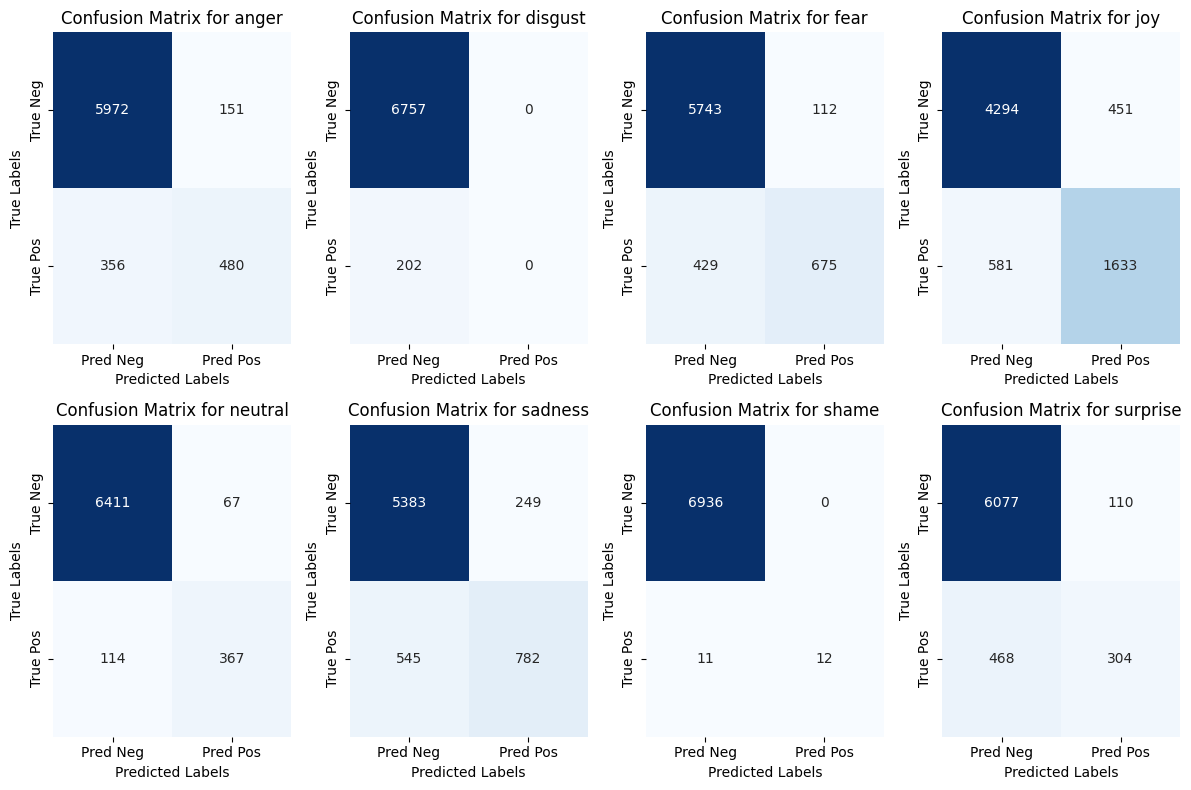

In [26]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute multi-label confusion matrix
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Step 2: Plot confusion matrix for each label
# This will create a matrix for each emotion, where:
# - Row 1 is true negatives, false positives
# - Row 2 is false negatives, true positives
labels = mlb.classes_

fig, axes = plt.subplots(2, 4, figsize=(12, 8))  # Adjust figure size
axes = axes.flatten()

for i in range(len(labels)):
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Neg", "Pred Pos"],
                yticklabels=["True Neg", "True Pos"], ax=axes[i], cbar=False)
    axes[i].set_title(f'Confusion Matrix for {labels[i]}')
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()
